# Object detection with Vision Transformers

**Author:** [Karan V. Dave](https://www.linkedin.com/in/karan-dave-811413164/)<br>
**Date created:** 2022/03/27<br>
**Last modified:** 2022/03/27<br>
**Description:** A simple Keras implementation of object detection using Vision Transformers.

## Introduction

The article
[Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
architecture by Alexey Dosovitskiy et al.
demonstrates that a pure transformer applied directly to sequences of image
patches can perform well on object detection tasks.

In this Keras example, we implement an object detection ViT
and we train it on the
[Caltech 101 dataset](http://www.vision.caltech.edu/datasets/)
to detect an airplane in the given image.

This example requires TensorFlow 2.4 or higher, and
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
from which we import the `AdamW` optimizer.

TensorFlow Addons can be installed via the following command:

```
pip install -U tensorflow-addons
```

## Imports and setup

In [2]:
# !pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
from bs4 import BeautifulSoup
from lxml import etree
from tqdm import trange
import pandas as pd
from wandb.keras import WandbCallback
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = "keras_example_object_detection_using_vision_transformer"

In [3]:
wandb.init("keras-plain-vit-10000-examples", entity="dsdc")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find keras_example_object_detection_using_vision_transformer.
wandb: Currently logged in as: charitarth-chugh (dsdc). Use `wandb login --relogin` to force relogin


In [4]:
from pathlib import Path
import gc

soup = None


def parse(file_pth: str) -> tuple[int]:
    soup = BeautifulSoup(Path(file_pth).read_text(), features="xml", )
    bndbox = soup.bndbox
    return (int(bndbox.xmax.text), int(bndbox.ymax.text), int(bndbox.xmin.text), int(bndbox.ymin.text))


def parse2(file_pth: str) -> tuple[int]:
    root = etree.fromstring(Path(file_pth).read_text())
    bndbox = root.xpath("//bndbox")[0]
    xmin = int(root.xpath("//xmin")[0].text)
    xmax = int(root.xpath("//xmax")[0].text)
    ymin = int(root.xpath("//ymin")[0].text)
    ymax = int(root.xpath("//ymax")[0].text)
    return xmax, ymax, xmin, ymin


parse2(
    "/run/media/cc/840Evo/Data/DACSystemsDesign/RandomAllImage_evaluation_V2.0-002/RandomAllImage_evaluation_V2.0/RimageXML_march50k/1000033414.xml")

(339, 240, 288, 157)

## Prepare dataset

We use the [Caltech 101 Dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/).

In [5]:
# Path to images and annotations
path_images = "/run/media/cc/840Evo/Data/DACSystemsDesign/RandomAllImage_evaluation_V2.0-002/RandomAllImage_evaluation_V2.0/Rimage_march50k/"
path_annot = "/run/media/cc/840Evo/Data/DACSystemsDesign/RandomAllImage_evaluation_V2.0-002/RandomAllImage_evaluation_V2.0/RimageXML_march50k/"

# path_to_downloaded_file = keras.utils.get_file(
#     fname="caltech_101_zipped",
#     origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1",
#     extract=True,
#     archive_format="zip",  # downloaded file format
#     cache_dir="/",  # cache and extract in current directory
# )

# # Extracting tar files found inside main zip file
# shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
# shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in trange(0, len(annot_paths[:10000])):
    # Access bounding box coordinates
    # annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]
    # annot = parse2(path_annot + annot_paths[i])
    # top_left_x, top_left_y = annot[2], annot[0]
    # bottom_right_x, bottom_right_y = annot[3], annot[1]
    top_left_x, top_left_y, bottom_right_x, bottom_right_y = parse(path_annot + annot_paths[i])
    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )
    gc.collect()
    # print((top_left_x,top_left_y,bottom_right_x,bottom_right_y))
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8):]),
    np.asarray(targets[int(len(targets) * 0.8):]),
)


100%|██████████| 10000/10000 [16:44<00:00,  9.96it/s]


## Implement multilayer-perceptron (MLP)

We use the code from the Keras example
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
as a reference.

In [6]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement the patch creation layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


## Display patches for an input image

2022-12-27 17:51:17.727864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 17:51:17.740233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 17:51:17.740372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 17:51:17.740799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


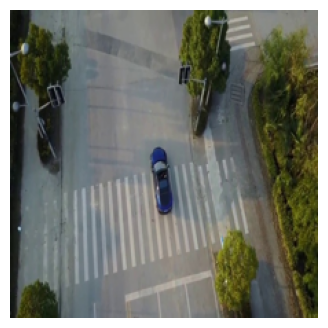

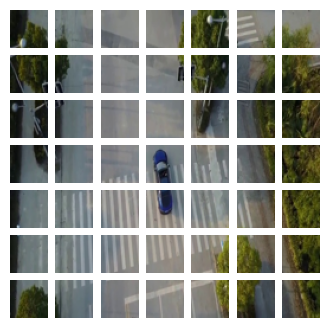

In [8]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer linearly transforms a patch by projecting it into a
vector of size `projection_dim`. It also adds a learnable position
embedding to the projected vector.

In [9]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model has multiple Transformer blocks.
The `MultiHeadAttention` layer is used for self-attention,
applied to the sequence of image patches. The encoded patches (skip connection)
and self-attention layer outputs are normalized and fed into a
multilayer perceptron (MLP).
The model outputs four dimensions representing
the bounding box coordinates of an object.

In [10]:

def create_vit_object_detector(
        input_shape,
        patch_size,
        num_patches,
        projection_dim,
        num_heads,
        transformer_units,
        transformer_layers,
        mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


## Run the experiment

In [11]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            WandbCallback(),
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history
    

input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = wandb.config.learning_rate = 0.001
weight_decay = wandb.config.weight_decay = 0.0001
batch_size = wandb.config.batch_size = 32
num_epochs = wandb.config.num_epochs = 100
num_patches = wandb.config.num_patches = (image_size // patch_size) ** 2
projection_dim = wandb.config.projection_dim = 64
num_heads = wandb.config.num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = wandb.config.transformer_layers = 4
mlp_head_units = wandb.config.mlp_head_units = [
    2048,
    1024,
    512,
    64,
    32,
]  # Size of the dense layers

history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
with tf.device("/gpu:0"):
    history = run_experiment(
        vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
    )


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-12-27 17:51:19.347397: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4335206400 exceeds 10% of free system memory.
2022-12-27 17:51:21.042903: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4335206400 exceeds 10% of free system memory.


Epoch 1/100
 13/225 [>.............................] - ETA: 3s - loss: 1.0102

2022-12-27 17:51:24.329394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


225/225 [==============================] - ETA: 0s - loss: 0.1736

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 12s 42ms/step - loss: 0.1736 - val_loss: 0.0250
Epoch 2/100
222/225 [============================>.] - ETA: 0s - loss: 0.0241

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 36ms/step - loss: 0.0241 - val_loss: 0.0176
Epoch 3/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0225 - val_loss: 0.0176
Epoch 4/100
224/225 [============================>.] - ETA: 0s - loss: 0.0221

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 36ms/step - loss: 0.0220 - val_loss: 0.0176
Epoch 5/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0216 - val_loss: 0.0176
Epoch 6/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0214 - val_loss: 0.0176
Epoch 7/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0208 - val_loss: 0.0176
Epoch 8/100
224/225 [============================>.] - ETA: 0s - loss: 0.0206

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 37ms/step - loss: 0.0206 - val_loss: 0.0175
Epoch 9/100
224/225 [============================>.] - ETA: 0s - loss: 0.0204

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 9s 38ms/step - loss: 0.0204 - val_loss: 0.0175
Epoch 10/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0200 - val_loss: 0.0175
Epoch 11/100
225/225 [==============================] - ETA: 0s - loss: 0.0200

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 9s 39ms/step - loss: 0.0200 - val_loss: 0.0175
Epoch 12/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0198 - val_loss: 0.0176
Epoch 13/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 14/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 15/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 16/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0193 - val_loss: 0.0175
Epoch 17/100
221/225 [============================>.] - ETA: 0s - loss: 0.0190

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 36ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 18/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 19/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 20/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0189 - val_loss: 0.0175
Epoch 21/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 22/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 23/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 24/100
224/225 [============================>.] - ETA: 0s - loss: 0.0188

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 37ms/step - loss: 0.0188 - val_loss: 0.0175
Epoch 25/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 26/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 27/100
225/225 [==============================] - 3s 15ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 28/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 29/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 30/100
224/225 [============================>.] - ETA: 0s - loss: 0.0187

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 9s 39ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 31/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 32/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 33/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 34/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 35/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 36/100
225/225 [==============================] - ETA: 0s - loss: 0.0187

INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best/assets
wandb: Adding directory to artifact (/home/cc/Dev/IdeaProjects/UConn/Ding/vit_object_detection_test/wandb/run-20221227_173431-zidsfvyy/files/model-best)... Done. 0.2s


225/225 [==============================] - 8s 37ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 37/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 38/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 39/100
225/225 [==============================] - 3s 15ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 40/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 41/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 42/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 43/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 44/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 45/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0187 - 

## Evaluate the model

1/1 [==============================] - 0s 13ms/step
mean_iou: 0.0


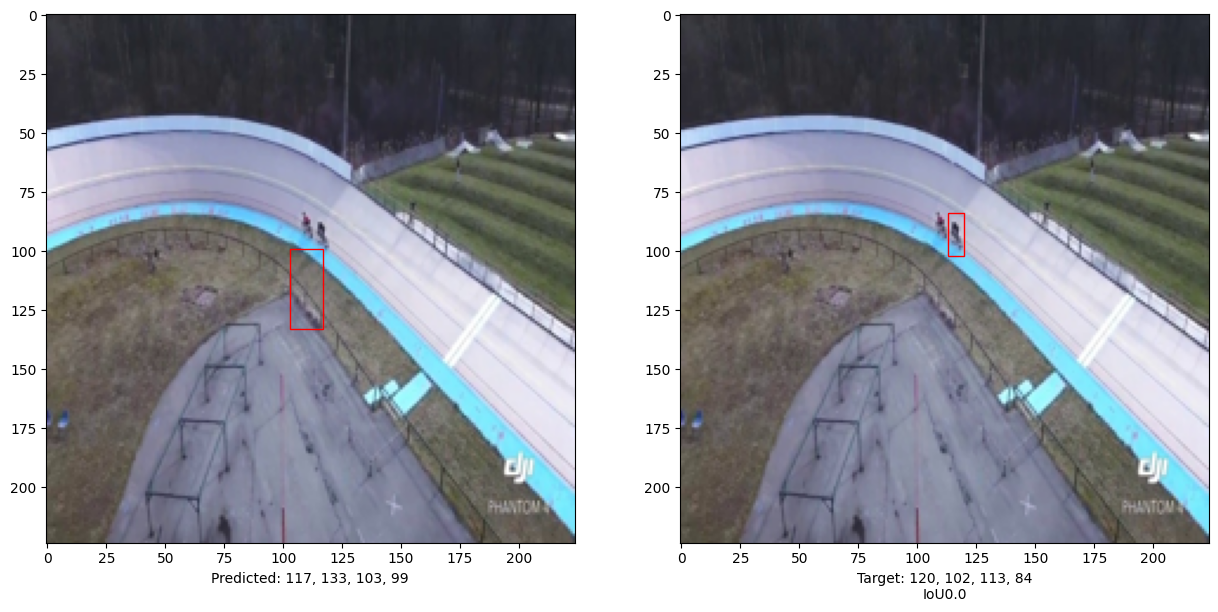

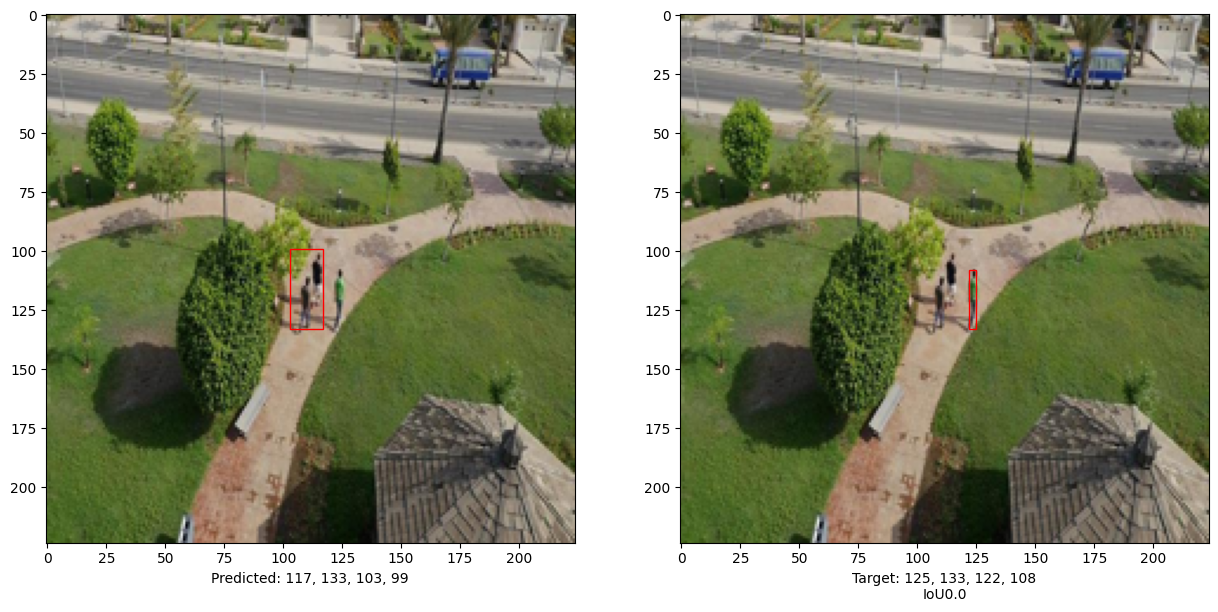

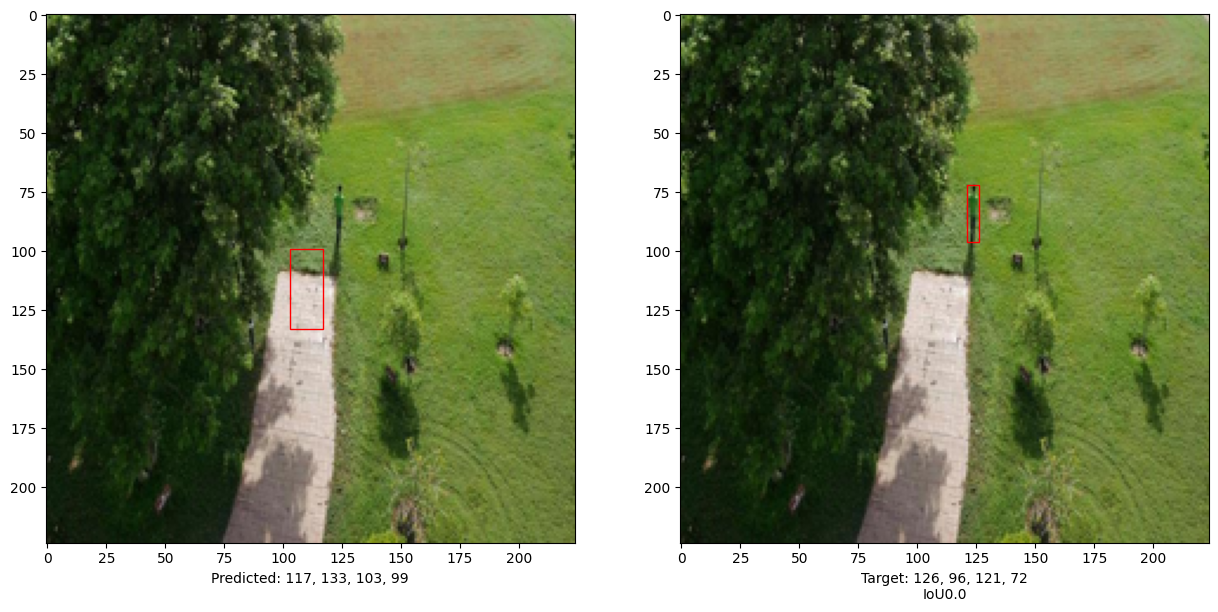

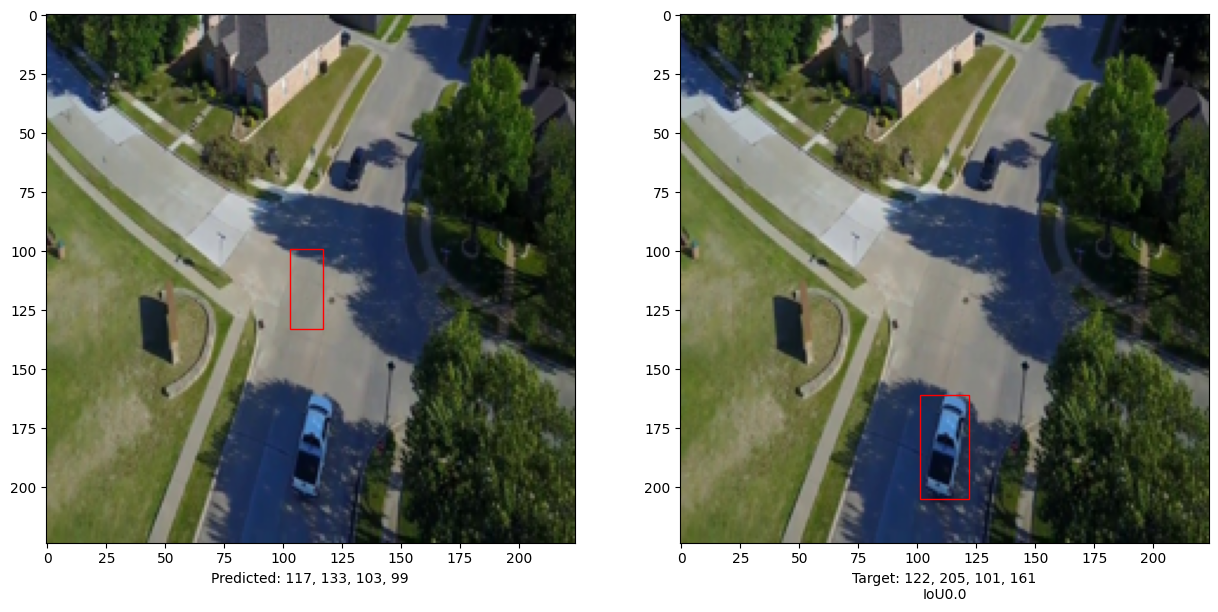

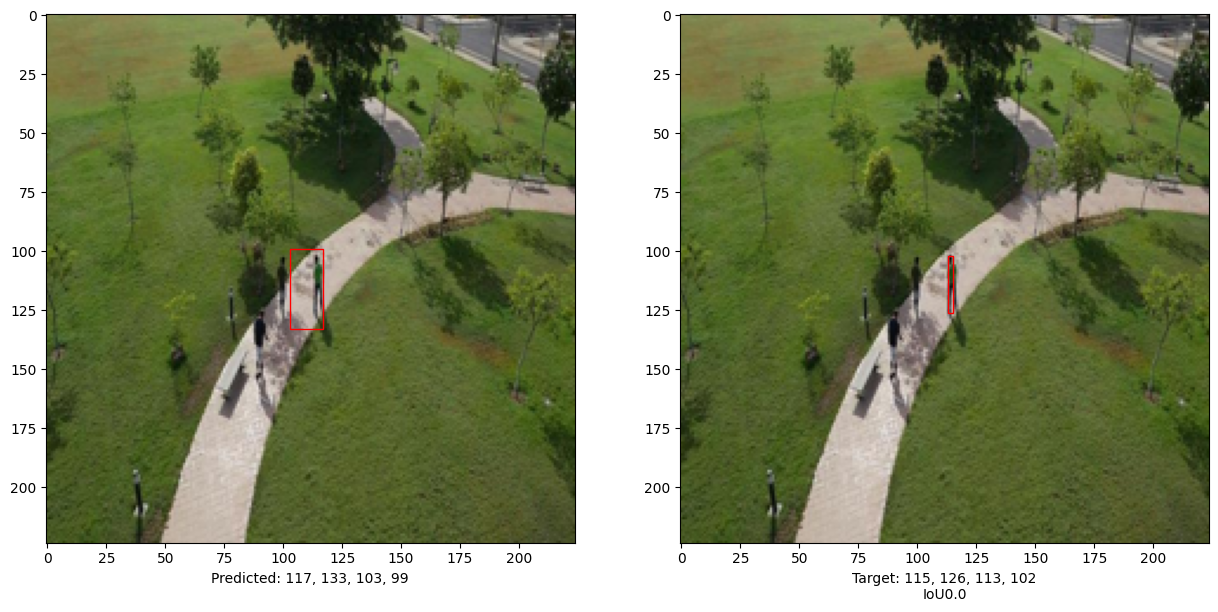

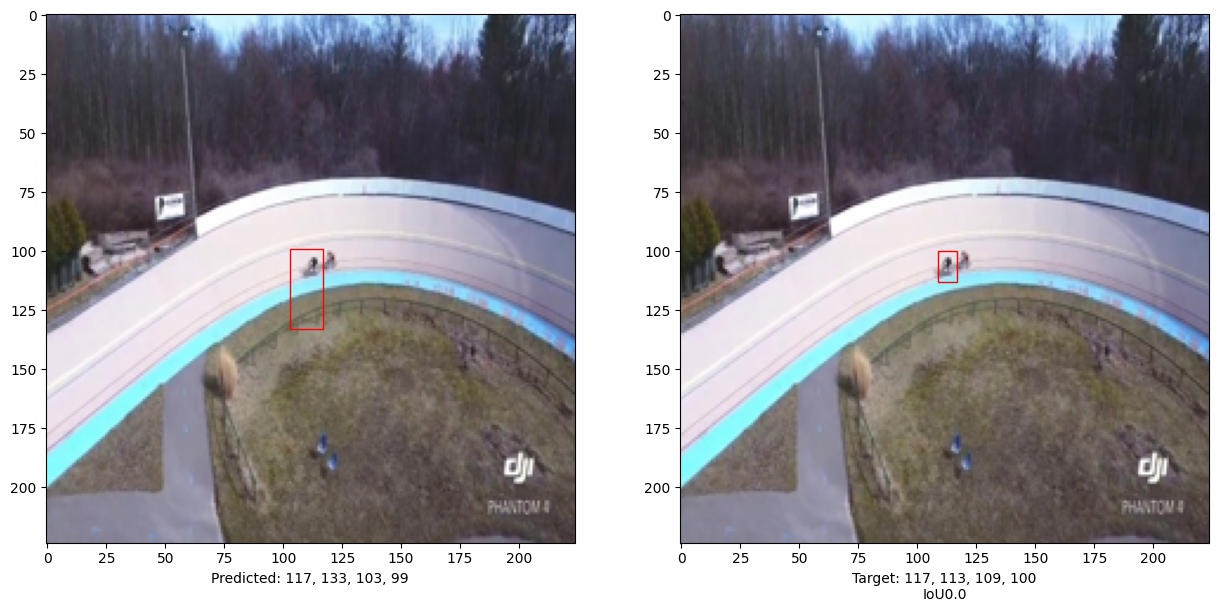

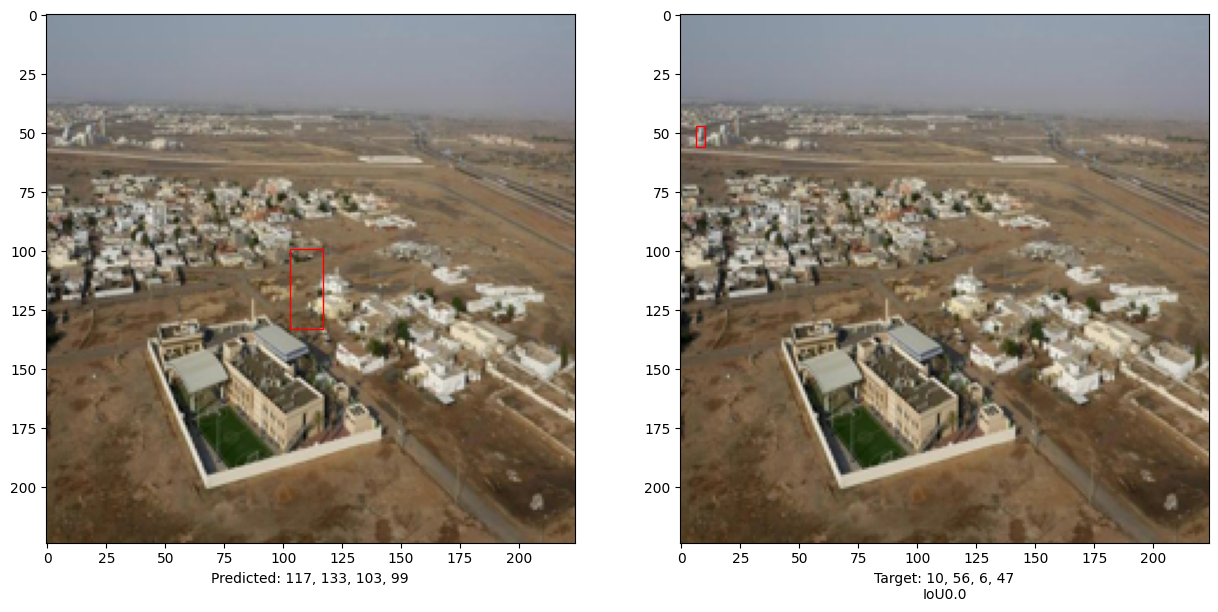

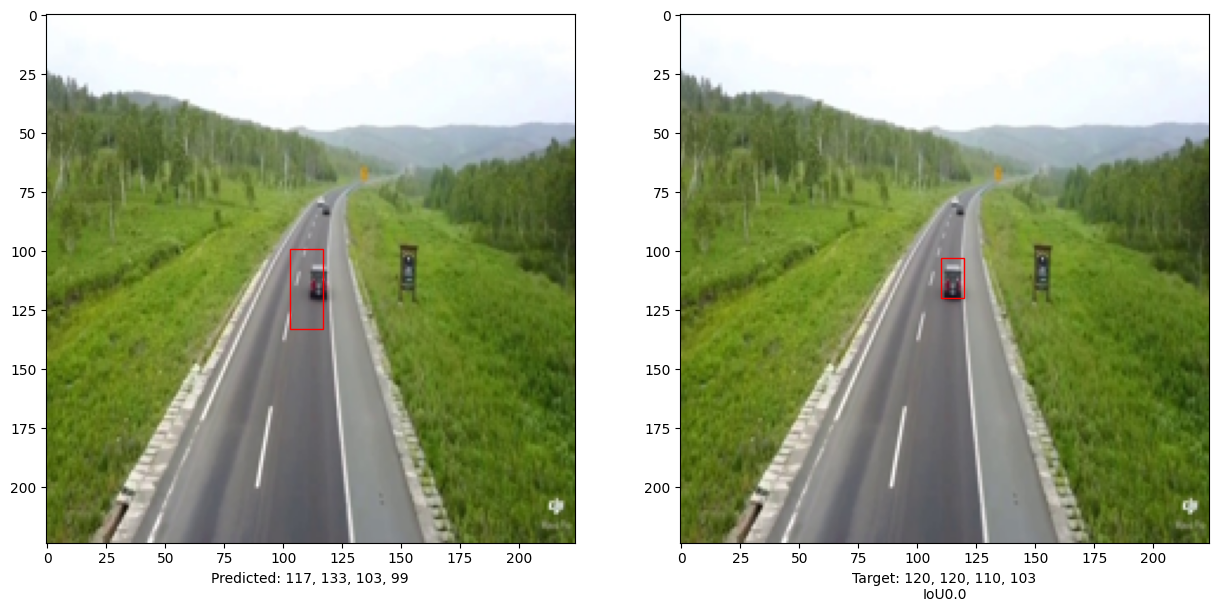

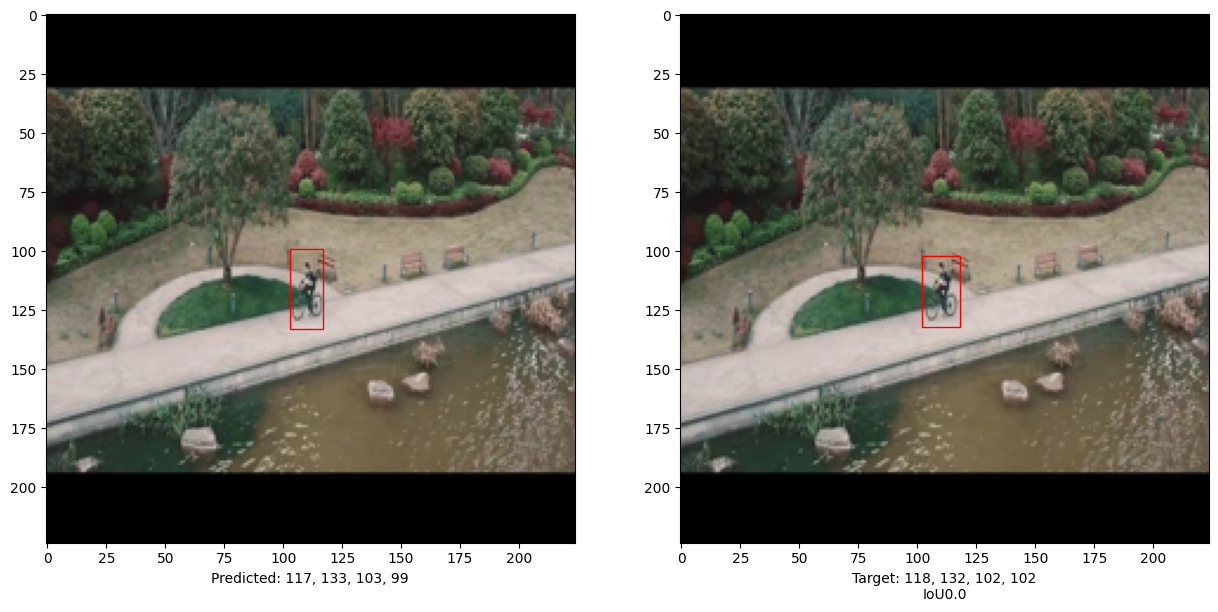

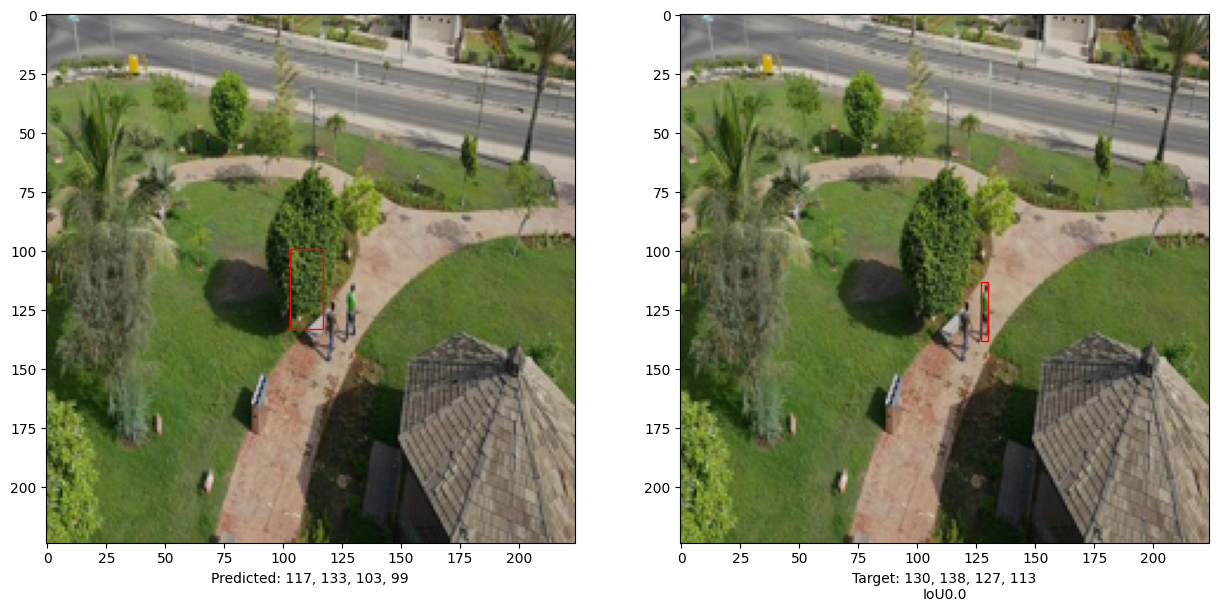

In [12]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
            box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
            box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

This example demonstrates that a pure Transformer can be trained
to predict the bounding boxes of an object in a given image,
thus extending the use of Transformers to object detection tasks.
The model can be improved further by tuning hyper-parameters and pre-training.

In [15]:
wandb.run.finish()

AttributeError: 'NoneType' object has no attribute 'finish'